# import

In [28]:
import torch
import pandas as pd
from glob import glob
import os

from torch.utils.data.dataset import Dataset
import cv2
from PIL import Image
import PIL
import numpy as np
from albumentations.pytorch import transforms
import albumentations as A
import timm
import matplotlib.pyplot as plt
import torchsummary
from tqdm import tqdm
import logging
from utils import MultiClassificationMetric
from einops import rearrange, reduce

from models.vggnet import VGGNet
from models.googlenet import GoogleNet
from models.resnet import ResNet
from models.densenet import DenseNet
from models.xception import Xception
from models.vit import ViT
from models.swin_transformer import SwinTransformer

In [78]:
# class 200, per 500

base = '/home/hebb/ml/datasets/imagenet_tiny/val'
imgs, labels = list(), list()

for cls in glob(f'{base}/*'):
    c = cls.split('/')[-1]
    
    for path in glob(f'{cls}/images/*'):
        imgs.append(path)
        labels.append(mapper[c])

In [70]:
df = pd.DataFrame()
df['img_path'] = imgs
df['label'] = labels
df.to_csv('../../datasets/imagenet_tiny/valid_data.csv')

In [2]:
df = pd.read_csv('../../datasets/stl_10/data.csv')

In [3]:
class Mnist(Dataset):
    def __init__(self, df, transforms=None):
        self.data = df
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        path, label = row['img_path'], row['label']
        img = np.array(Image.open(path))
        img = np.expand_dims(img, -1)
        img = np.concatenate([img, img, img], axis=-1)
        img = self.transforms(image=img) if self.transforms else img
        label = int(label)
        
        return img, label 

In [19]:
class STL_10(Dataset):
    def __init__(self, df, transforms=None):
        self.data = df
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        path, label = row['img_path'], row['label']
        img = np.array(Image.open(path))
        img = np.expand_dims(img, -1)
        img = self.transforms(image=img) if self.transforms else img
        label = int(label)
        
        return img, label 

In [20]:
transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=0.5, std=0.5),
        transforms.ToTensorV2()
    ]
)

In [21]:
ds = STL_10(df)
loader = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True)

In [23]:
img, label = ds.__getitem__(110)
img.shape

(96, 96, 3, 1)

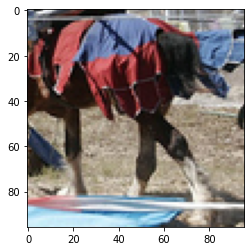

In [41]:
img, label = ds.__getitem__(505)
rearrange
plt.imshow(np.transpose(reduce(img, 'h w c b -> c w h', 'max')), cmap='gray')

In [42]:
model = SwinTransformer(num_classes=10)
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=2e-05, weight_decay=1e-8)

metric = MultiClassificationMetric()

/home/hebb/anaconda3/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [43]:
for epoch in range(10):
    import os
    if os.path.exists('train.log'):
        os.remove('train.log')
    logger = logging.Logger('train')
    handler = logging.FileHandler('train.log')
    logger.addHandler(handler)

    model.train()
    model.to('cuda:0')

    ep_loss = 0
    ep_acc = 0
    step = 0
    
    print('> loader len: ', len(loader))

    for data in tqdm(loader):
        step += 1

        img, label = data
        img = img['image'].type(torch.float32)
        img = img.to('cuda:0')
        label = torch.tensor(label, dtype=torch.float32).to('cuda:0')
        pred = model(img)
        pred = pred.type(torch.float32)
        pred.requires_grad_(True)

        loss = criterion(pred, label.type(torch.int64))
        optim.zero_grad()
        loss.backward()
        optim.step()

        ep_loss += loss
        top_1, top_k = metric.get_top_k(pred, label, 5)
        
        # if step == 8:
        #     optim.step()
        #     optim.zero_grad()
        #     step = 0
        
        logger.info(f'top_1: {top_1}, top_k: {top_k}, loss: {loss}')

    print('loss: ', ep_loss / len(loader.dataset))
    print('acc: ', ep_acc / len(loader.dataset))
        

> loader len:  79


  0%|          | 0/79 [00:00<?, ?it/s]


TypeError: new(): invalid data type 'str'

In [ ]:
t = torch.tensor([2, 3])
t.numpy()

array([2, 3])